# Lectures on Machine Learning for Strong Gravity
## Lecture 1: Physics-Informed Neural Networks

To test it, simply press Ctrl+Enter sequentially in each cell, or click on the small icons on the left with the "play" symbol.

<br>

<a href="https://colab.research.google.com/github/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This lecture introduces the concept of physics-informed neural networks (PINNs), and how we can use them to solve differential equations and eigenvalue problems. PINNs were introduced in:

 - https://arxiv.org/abs/1711.10561

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display

In [3]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

def generate_2Dgrid(minimum1, maximum1, minimum2, maximum2, N):
    grid1 = np.linspace(minimum1, maximum1, N, dtype = np.float32)
    grid2 = np.linspace(minimum2, maximum2, N, dtype = np.float32)
    x0, y0 = np.meshgrid(grid1, grid2)
    x = torch.tensor(x0.reshape(N**2), requires_grad = True)
    y = torch.tensor(y0.reshape(N**2), requires_grad = True)
    return x, y

def plot_form(x, y, z, N):
    return map(lambda t: t.reshape(N,N).cpu().detach().numpy(), (x, y, z))

# 1. Automatic differentiation and optimization

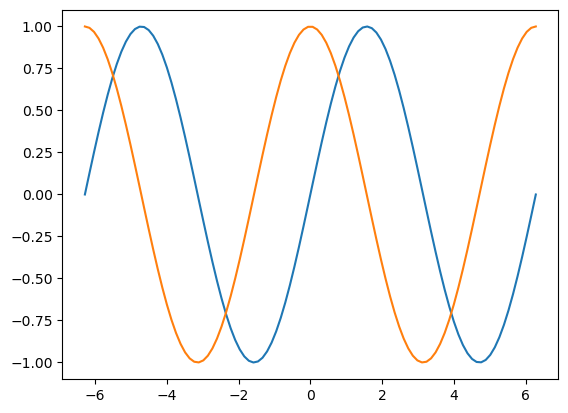

In [4]:
x = torch.tensor(np.linspace(-2*np.pi, 2*np.pi, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

y = torch.sin(x)

dydx = gradients(y, x)
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.plot(x.detach().numpy(), dydx.detach().numpy())

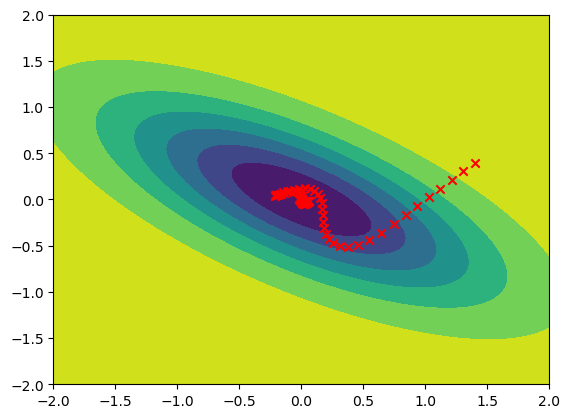

In [37]:
x = torch.tensor([1.5], requires_grad = True)
y = torch.tensor([0.5], requires_grad = True)

track = []

optimizer = optim.Adam([x, y], lr=0.1)

for i in range(100):
    optimizer.zero_grad()

    z = 1 - torch.exp( -(x + y)**2 - y**2  )
    z.backward()

    optimizer.step()
    track.append([x.item(), y.item()])

track = np.array(track)

x0, y0 = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
plt.contourf(x0, y0, 1 - np.exp( -(x0 + y0)**2 - y0**2  ))
plt.scatter(track[:, 0], track[:, 1], color = 'red', marker='x')

## Challenges!
 - Try computing derivatives of other functions
 - Try changing the learning rate. What happens if it gets too small? Or too big?

# 2. Solving a system of ODEs: Sine and Cosine

Here we solve the system of ODEs

$$s'(x) = c(x),$$
$$c'(x) = s(x),$$

with the initial conditions

$$s(0) = 0, \;c(0) = 1.$$

We impose the initial conditions by weak enforcement.

<br>

In [21]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x)
    
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
        
    def forward(self, x):
        
        funcs  = self.ode(x)
        
        c, s = map(lambda i:  funcs[:,[i]], range(2))
        dc = gradients(c, x)
        ds = gradients(s, x)
        
        zero_vals = self.ode(torch.zeros(1,1))
                
        eq_loss = torch.mean((dc + s)**2 + (ds - c)**2)
        ic_loss = (zero_vals[0,0] - 1)**2 + zero_vals[0,1]**2
        
        return eq_loss, ic_loss
    

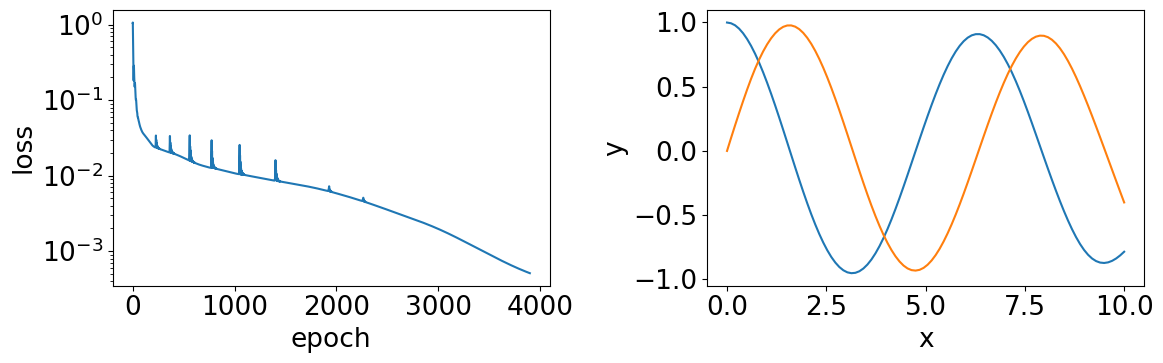

In [23]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.05)**(1/4000))

x = torch.tensor(np.linspace(0, 10, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

data_loader = DataLoader(xx,  batch_size=10, num_workers=8, pin_memory=True)

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(4000):
    try:
        optimizer.zero_grad()

        eq_loss, ic_loss = odeloss(x)
        loss = eq_loss + ic_loss
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        loss_hist.append(loss.item())
        
        if epoch % 100 == 0:
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)

            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(xx.cpu().detach().numpy(), ode(xx)[:, 0].cpu().detach().numpy())
            ax2.plot(xx.cpu().detach().numpy(), ode(xx)[:, 1].cpu().detach().numpy())

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

## Challenge!

 - Try imposing the conditions at $x = 2\pi$ instead of at $x = 0$. Does it affect the performance?

<br>

# 3. Simple Eigenvalue Problem: Vibrating String

Here we try to solve the eigenvalue problem

$$f''(x) + \lambda^2 f(x) = 0, \quad f(0) = f(1) = 0.$$

<br>

In [18]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()
        
        self.lam = nn.Parameter(torch.tensor(5.0, requires_grad = True))

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x) * x * (1 - x) 
    
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
        
    def forward(self, x):
        f  = self.ode(x)
        d2f = gradients(f, x, 2)
                
        loss = torch.mean((d2f + f*self.ode.lam**2)**2) + (torch.mean(torch.abs(f)) - 1)**2
        
        return loss

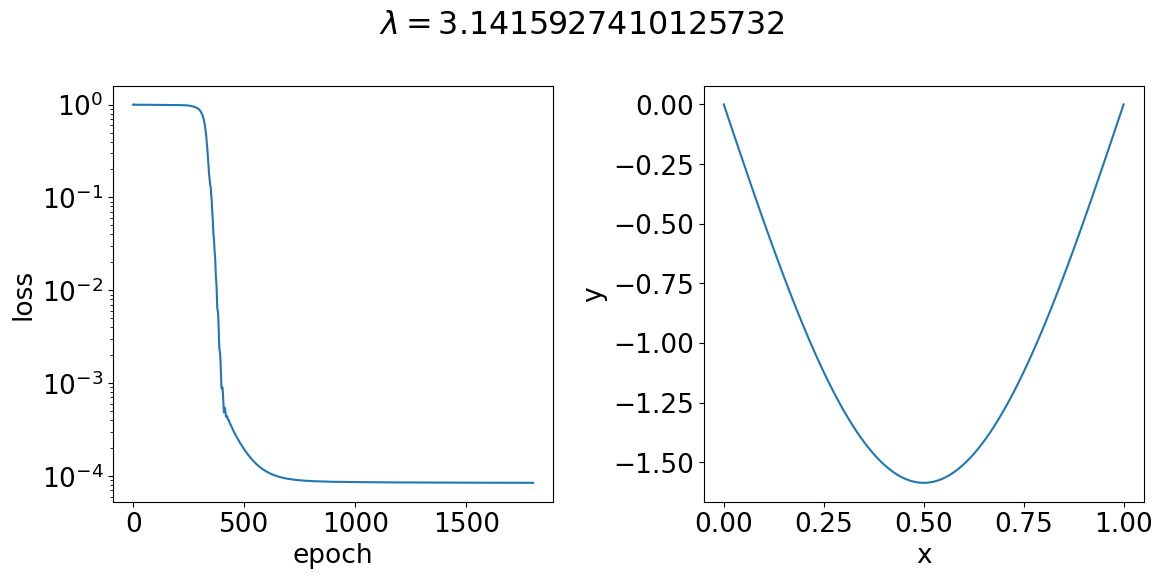

In [19]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
x = torch.tensor(np.linspace(0, 1, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(2000):
    try:
        optimizer.zero_grad()

        loss = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())

        if epoch % 100 == 0:
            
            plt.suptitle(f'$\lambda = {ode.lam.item()}$')
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

## Challenge!

 - Try solving the eiganvalue problem 

$$x^2 f''(x) + x f'(x) + \lambda^2 x^2 f(x) = 0, \quad f(0) = 1, \; f(1) = 0$$

<br>

# 4. Solving an Elliptic PDE: Poisson's Equation on a Disk

Now we switch to a 2-dimensional case. Let's solve Poisson's equation 

$$\nabla^2 u = - r^2 \sin (\theta / 2)^4 + \sin(6\theta) \cos (\theta / 2)^2,$$

on a unit disk, with the boundary condition

$$u(r=1) = 0$$

<br>

In [56]:
class PDE(nn.Module):
    def __init__(self):
        super(PDE, self).__init__()
        
        self.lam = nn.Parameter(torch.tensor(1.0, requires_grad = True))
                
        self.net = nn.Sequential(
            nn.Linear(3, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias,  val = 0.0)
                
    def forward(self, r, th):
        rth  = torch.stack((r**2, r**2 * torch.sin(th), r**2 * torch.cos(th)), 1)
        bdry = (r**2 - 1).reshape(len(r), 1)
        net_out = self.net(rth) * bdry
        return net_out
    
    
class PDELoss(nn.Module):
    def __init__(self, pde):
        super(PDELoss, self).__init__()
        self.pde = pde
        
    def forward(self, r, th):
        u   = self.pde(r, th)
        u10 = gradients(u, r, 1)
        u20 = gradients(u, r, 2)
        u02 = gradients(u, th, 2)
        
        r2_lap_u = r**2 * u20 + r * u10 + u02
        source   = - r**2 * torch.sin(th/2)**4 + torch.sin(6*th) * torch.cos(th/2)**2
        
        loss = torch.mean(torch.abs( r2_lap_u  - r**2 * source ))
        
        return loss

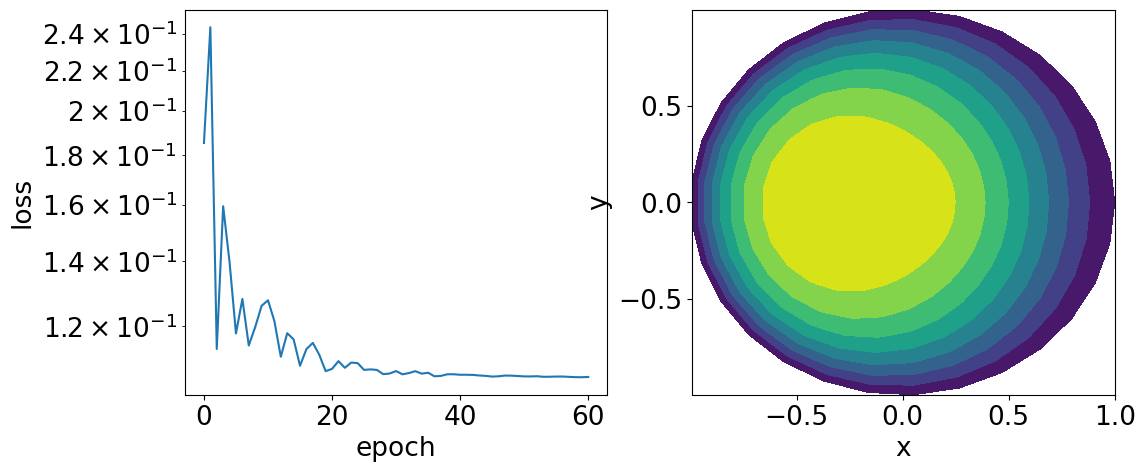

In [66]:
pde      = PDE()
pde_loss = PDELoss(pde)
loss_hist = []

r, th = generate_2Dgrid(0, 1, 0, 2*np.pi, 30)
optimizer = optim.Adam(pde.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5));
font = {'size'   : 19}
plt.rc('font', **font)

for it in range(5000):
    try:
        optimizer.zero_grad()

        loss = pde_loss(r, th)
        loss_hist.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if  it %10 == 0:
            r_plot, th_plot, u_plot = plot_form(r, th, pde(r, th), 30)
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.contourf(r_plot * np.cos(th_plot), r_plot * np.sin(th_plot), u_plot)
            
            display.display(plt.gcf())
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        break

<IPython.core.display.Javascript object>


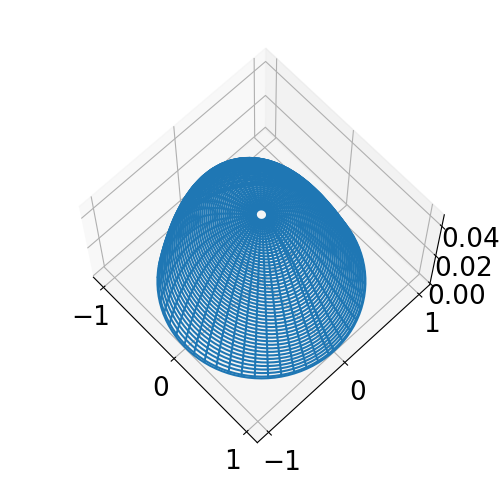

In [67]:
%matplotlib notebook

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection='3d')

r, th = generate_2Dgrid(0.05, 1, 0, 2*np.pi, 100)
r_plot, th_plot, u_plot = plot_form(r, th, pde(r, th), 100)

ax.plot_wireframe(r_plot * np.cos(th_plot), r_plot * np.sin(th_plot), u_plot);

## Challenge!
 - How would you change the boundary condition to be 

$$u(r=1) = 0.01 \sin(2\theta)$$

<br>

In [68]:
#Go back to regular plots!
%matplotlib inline

# 5. The Teukolsky Equation (Quasinormal Modes of Kerr)

Let's now find quasinormal modes of Kerr black holes. This part is based on https://arxiv.org/abs/2212.06103. In this case, the equation we try to solve is Teukolsky's equation. After separation of variables, we are left with

$$\Delta(r) R''(r) + (s+1) (2r -1)R'(r) +V(r)R(r)=0,$$

$$(1-u^2)S''(u) - 2u S'(u) + \left[a^2\omega^2 u^2 - 2 a\omega s u + s + A -\frac{(m+su)^2}{1-u^2}\right]S(u) = 0,
$$

where we defined

$$\Delta(r) = r^2 - r + a^2, \qquad V(r) = \alpha(r) \omega^2 + \beta(r) \omega + \gamma(r), $$

$$\alpha(r) = \frac{(r^2+a^2)^2}{\Delta(r)} - a^2, \qquad \beta(r) = \frac{is (a^2 - r^2) - 2amr }{\Delta(r)} + 2isr, \qquad \gamma(r) = \frac{a^2 m^2 + i s a m (2r - 1)}{\Delta(r)} - A. $$

We define the functions $f(x)$ and $g(u)$, with $x = 1/r$ and $u = \cos \theta$, as

$$R(r) = e^{i \omega r} (r - r_-)^{p_-} (r - r_+)^{p_+} f(x),$$

$$S(u) = e^{a \omega u} (1 + u)^{|m-s|/2} (1 - u)^{|m+s|/2} g(u),$$

with

$$p_- = -1-s+i\omega+i\sigma_+, \qquad p_+ = -s-i\sigma_+, \qquad \sigma_+ = \frac{\omega r_+ - a m}{\sqrt{1 - 4 a^2}}.$$

We impose the normalization condition $f(1) = g(-1) = 1.$

<br>

In [31]:
from pycbc.waveform import ringdown as rd

def gradients(outputs, inputs, order = 1):
    
    re_outputs = torch.real(outputs)
    im_outputs = torch.imag(outputs)
    if order == 1:
        d_re = torch.autograd.grad(re_outputs, inputs, grad_outputs=torch.ones_like(re_outputs), create_graph=True)[0]
        d_im = torch.autograd.grad(im_outputs, inputs, grad_outputs=torch.ones_like(im_outputs), create_graph=True)[0]
        return d_re + (0 + 1j) * d_im
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

class PyCBC_modes():
    def __init__(self, l, m):
        self.l = l
        self.m = m
        
    def __call__(self, spin, n=0):
        c  = 299792458
        GM = 1.32712440018e20
        freq, tau = rd.get_lm_f0tau_allmodes(1, 2*spin, [f'{self.l}{self.m}8'])
        freq, tau = freq[f'{self.l}{self.m}{n}'], tau[f'{self.l}{self.m}{n}']
        wreal =  freq * (4 * np.pi * GM) / c**3
        wimag = - 1 / (tau * c**3 / (2 * GM))
        return complex(wreal, wimag)
        

In [29]:
class ODE(nn.Module):
    
    def __init__(self, l, m):
        super(ODE, self).__init__()
        
        # Spherical harmonic indices l and m
        self.l = torch.tensor(l)
        self.m = torch.tensor(m)
        
        #Initialize the eigenvalues omega and A_{lm} to sensible values
        self.w   = nn.Parameter(torch.tensor(0.7 - 0.1j), requires_grad = True)
        self.Alm = nn.Parameter(torch.tensor(l*(l+1) - 2.0 + 0.0j), requires_grad = True)
        
        #Net for R(x)
        self.netR = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 2),
        )
        
        #Net for S(x)
        self.netS = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 2),
        )

        #Random initialization of the netwok parameters
        torch.manual_seed(42)
        for m in self.netR.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.05)
                nn.init.constant_(m.bias, val = 0.0)
                              
        for m in self.netS.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.01)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x, u):
        #Evaluate the neural networks and apply hard enforcement of normalization
        outR = self.netR(x)
        outS = self.netS(u)       
        complex_resultR = outR[:,[0]] + 1j * outR[:,[1]]
        complex_resultS = outS[:,[0]] + 1j * outS[:,[1]]
        hard_enforceR   = (torch.exp(x - 1) - 1) 
        hard_enforceS   = (torch.exp(u + 1) - 1)
        
        return complex_resultR * hard_enforceR + 1, complex_resultS * hard_enforceS + 1
    
class ODELoss(nn.Module):
    
    def __init__(self, ode, a):
        super(ODELoss, self).__init__()
        
        self.ode = ode
        self.a   = torch.tensor(a)
        self.l   = ode.l
        self.m   = ode.m
        
    def forward(self, x_0, u):
        
        #Recover eigenvalues
        w   = self.ode.w
        Alm = self.ode.Alm
        
        #Compute some common expressions
        a = self.a
        m = self.m
        b = torch.sqrt(1 - 4*a**2)
        abs1 = torch.abs(self.m + 2)
        abs2 = torch.abs(self.m - 2)
        
        rp = (1 + b) / 2
        
        #Evaluate f, g, and their derivatives
        f, g = self.ode(x_0, u)
        df    = gradients(f,  x_0) #* rp
        ddf   = gradients(df, x_0) #* rp**2
        dg    = gradients(g,  u)
        ddg   = gradients(dg, u)
    
        #Teukolsky master equations (power series part)
        
        x = x_0 #/ rp
        
        eqf = ddf*x**2*(1 + x*(-1 + a**2*x))**2 + df*(1 + x*(-1 + a**2*x))*(x*(-2 - (b + 2j*a*m)*x + 2*a**2*x**2) + 2j*w*(-1 + (1 - a**2 + b)*x**2)) + (f*(2*w*(1j*(3 + b) - 2*a*m - a**2*w + 2*(1 + b)*w) + 2*(b - 2j*(1 + b)*w + a**2*w**2 - 2*a*m*(1j + w))*x + (-4*a**3*m*w - 2*a**4*w**2 + 2*a*(1 + b)*m*(1j + 2*w) - (1 + b)*(1 + 4*w**2) + 2*a**2*(2 + 1j*(1 + b)*w + 2*(3 + b)*w**2))*x**2 - 2*Alm*(1 + x*(-1 + a**2*x))))/2.
        eqg = g*(4*(2 + m**2 - 4*m*u + 2*u**2 + Alm*(-1 + u**2) - 2*a*u*w + 2*a*u**3*w - a**2*w**2 + a**2*u**2*w**2) - (1 + u)**2*abs2**2 - 2*(-1 + u**2)*(1 + 2*a*(-1 + u)*w)*abs1 - (-1 + u)**2*abs1**2 - 2*(-1 + u**2)*abs2*(1 + 2*a*(1 + u)*w + abs1)) - 4*(-1 + u**2)*(ddg*(-1 + u**2) + dg*(2*(u - a*w + a*u**2*w) + (1 + u)*abs2 + (-1 + u)*abs1))
        
        #Notice the radial and angular equations have weights of 10/1
        eq_loss = 10*torch.mean(torch.abs(eqf)) + torch.mean(torch.abs(eqg))
            
        return eq_loss

In [32]:
l, m = 2, 0
ode = ODE(l, m)
right_modes = PyCBC_modes(l, m)

#Definig the grid
x = torch.tensor(np.linspace(0.0,  1.0, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True
u = torch.tensor(np.linspace(-1.0, 1.0, 100, dtype = np.float32)).reshape(100, 1)
u.requires_grad = True

In [33]:
#You can evaluate this cell on a pre-trained network
a    = 0.45
target_mode = right_modes(a)

loss_hist = []
odeloss   = ODELoss(ode, a)
optimizer = optim.Adam(ode.parameters(), lr = 0.005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

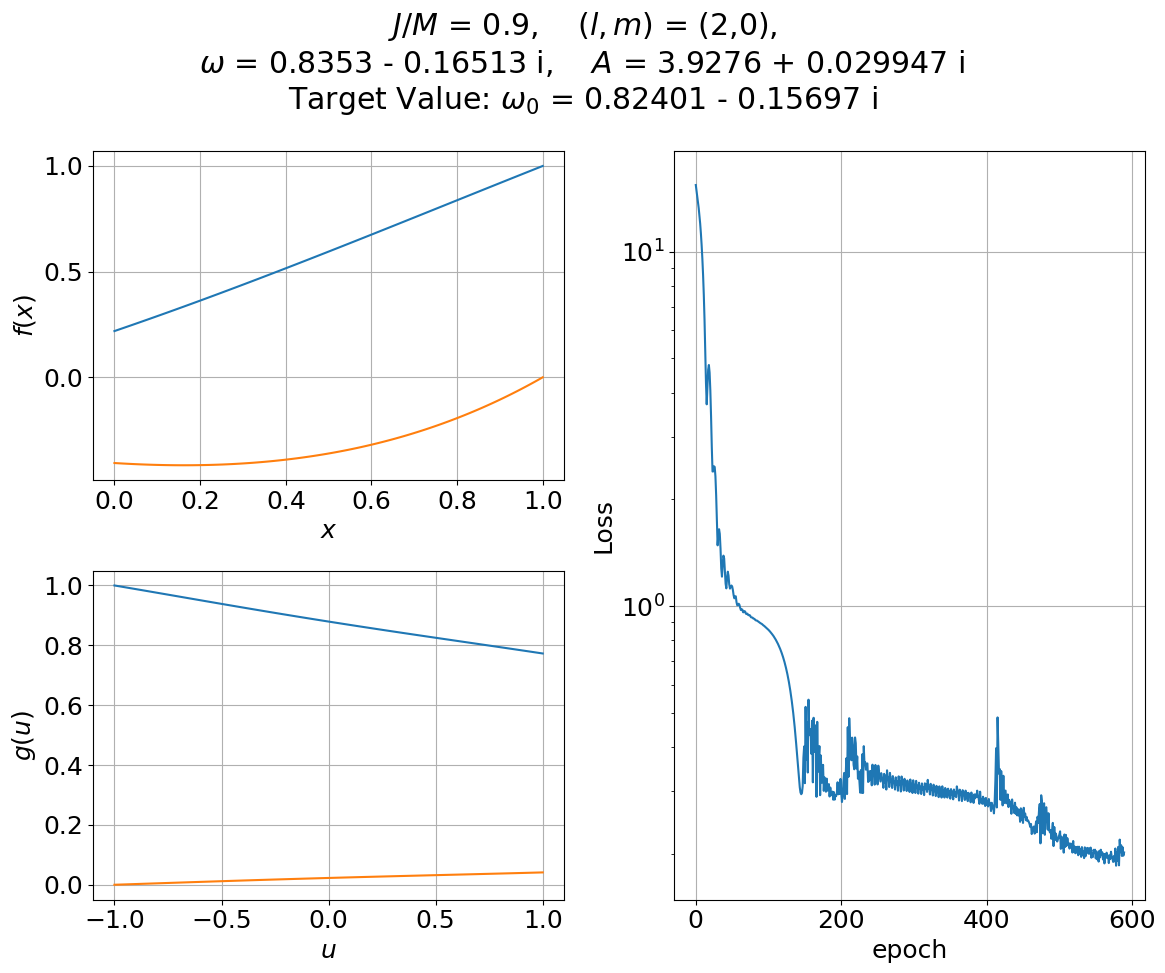

In [39]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize = (12, 10))
font = {'size'   : 18}
plt.rc('font', **font)

# set up subplot grid
gridspec.GridSpec(2,4)

for epoch in range(2000):
    try:
        #Training step
        optimizer.zero_grad()

        loss = odeloss(x, u)
        loss_hist.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 10 == 0:
            
            #Visualization
            f, g = ode(x, u)
            
            plt.suptitle(f'$J/M$ = {2*a},    ($l, m$) = ({l},{m}),\n' + \
                         f'$\omega$ = {np.real(ode.w.item()):.5} - {-np.imag(ode.w.item()):.5} i,    ' + \
                         f'$A$ = {np.real(ode.Alm.item()):.5} + {np.imag(ode.Alm.item()):.5} i \n' + \
                         f'Target Value: $\omega_0$ = {np.real(target_mode):.5} - {-np.imag(target_mode):.5} i' )

            plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=1)
            plt.cla()
            plt.plot(x.cpu().detach().numpy(), np.real(f.cpu().detach().numpy()), label = '$Re\; [f]$')
            plt.plot(x.cpu().detach().numpy(), np.imag(f.cpu().detach().numpy()), label = '$Im\; [f]$')
            plt.grid()
            #plt.legend(loc = 'upper left')
            plt.xlabel('$x$')
            plt.ylabel('$f(x)$')
            
            plt.subplot2grid((2,4), (1,0), colspan=2, rowspan=1)
            plt.cla()
            plt.plot(u.cpu().detach().numpy(), np.real(g.cpu().detach().numpy()), label = '$Re\; [g]$')
            plt.plot(u.cpu().detach().numpy(), np.imag(g.cpu().detach().numpy()), label = '$Im\; [g]$')
            plt.grid()
            #plt.legend(loc = 'center left')
            plt.xlabel('$u$')
            plt.ylabel('$g(u)$')
            
            plt.subplot2grid((2,4), (0,2), colspan=2, rowspan=2)
            plt.cla()
            plt.yscale('log')
            plt.plot(loss_hist)
            plt.grid()
            plt.xlabel('epoch')
            plt.ylabel('Loss')
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
                        
    except KeyboardInterrupt:
        break


## Challenges!
 - Try changing the angular momentum parameter $a$, and see how the mode changes.
 - Can you get a higher mode? Say, the (2,2,1) mode?
 - What happens if you train on a smaller $x$ range?
<br>